In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import MaxNLocator

from collections import defaultdict
from typing import Dict, List

# from importlib import reload
# reload(plt)
# plt.xlabel("Hello World")

plt.rcParams['figure.figsize'] = [14, 8]

# Plotting randomness analysis results

In [13]:
class ThreadDistribution:
    
    def __init__(self, buckets_to_counts, thread_count: int):
        self.buckets_to_counts = buckets_to_counts
        self.thread_count = thread_count
        
    def to_x_y(self):
        x = self.buckets_to_counts.keys()
        y = self.buckets_to_counts.values()
        return list(x), list(y)

class Distribution:
    ARRAY_SIZE = 10000000
    
    def __init__(self, bucket_multiplier: float, bucket_size: int):
        self.bucket_multiplier = bucket_multiplier
        self.bucket_size = bucket_size
        self.thread_distributions = []
        
    def add_thread_distribution(self, buckets_to_counts, thread_count: int):
        self.thread_distributions.append(ThreadDistribution(buckets_to_counts, thread_count))
        
    def get_bucket_count(self):
        return int(Distribution.ARRAY_SIZE / self.bucket_size * self.bucket_multiplier)

def read_slurm(filename: str):
    distributions = []
    add_new = False
    bucket_multiplier = -1
    bucket_size = -1
    thread_count = -1
    buckets_to_counts = {}
    
    with open(filename, "r") as handle:
        for line in handle.readlines():
            if line.startswith("Threads: 1\n"):
                if thread_count > 0:
                    distributions[-1].add_thread_distribution(buckets_to_counts, thread_count)
                    buckets_to_counts = {}
                thread_count = 1
                add_new = True
                
            elif line.startswith("Bucket count multiplier"):
                bucket_multiplier = float(line.split(': ')[1])
                
            elif line.startswith("Bucket size"):
                bucket_size = int(line.split(': ')[1])
                if add_new:
                    add_new = False
                    distributions.append(Distribution(bucket_multiplier, bucket_size))
                    
            elif line.startswith("Buckets with"):
                el_in_bucket = int(line.split("with ")[1].split(' ')[0])
                avg_bucket_count = float(line.split("elements:")[1])
                buckets_to_counts[el_in_bucket] = avg_bucket_count
                
            elif line.startswith("Threads: "):
                distributions[-1].add_thread_distribution(buckets_to_counts, thread_count)
                buckets_to_counts = {}
                thread_count = int(line.split("Threads: ")[1])
                
        distributions[-1].add_thread_distribution(buckets_to_counts, thread_count)    # append last one
        return distributions

def single_legend(proc: int):
    return f"{proc} processors"
    
def plot_distributions(distributions):
    for dist in distributions:
        for i, thread_dist in enumerate(dist.thread_distributions):
            x, y = thread_dist.to_x_y()
            plt.plot(x, y, marker = 'o', linestyle='--', label=single_legend(i+1))
            
        ax = plt.axes()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(f"Bucket size distribution for starting bucket size {dist.bucket_size} and bucket count {dist.get_bucket_count()}")
        plt.ylabel("Bucket count")
        plt.xlabel("Bucket size")
        plt.legend()
        plt.savefig(f"dist{dist.bucket_size}_{dist.bucket_multiplier}.png")
        plt.show()

<ipython-input-13-16cc9cd0c96c>:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


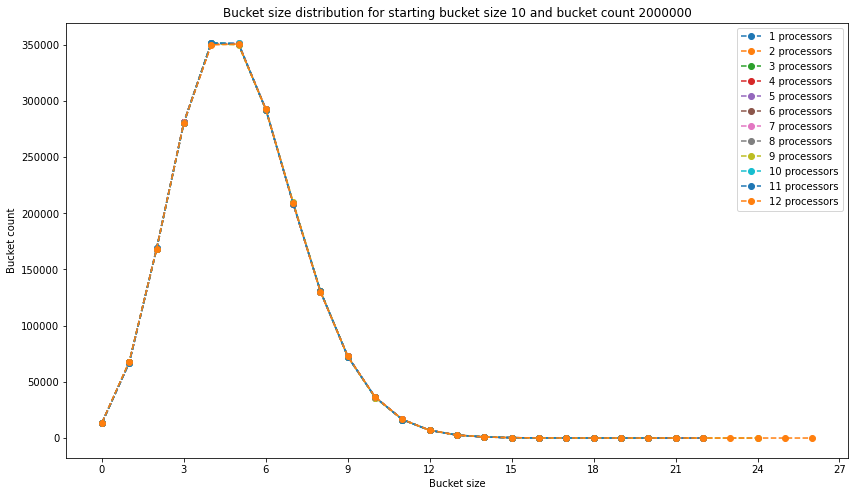

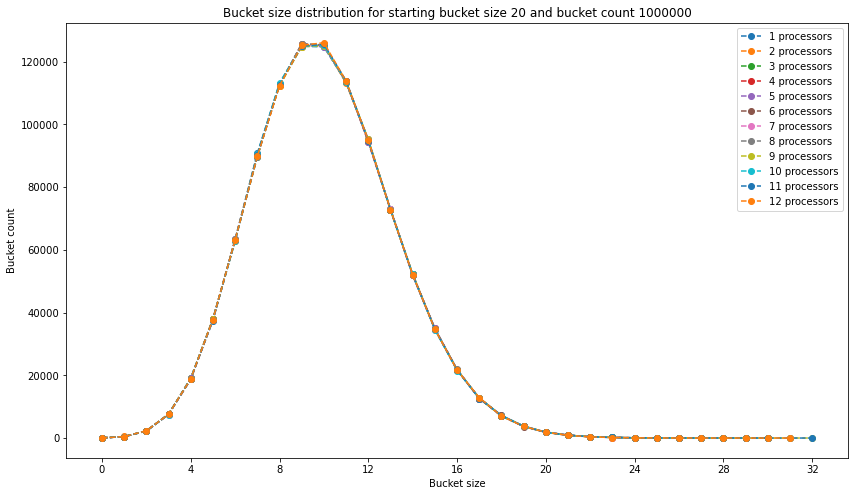

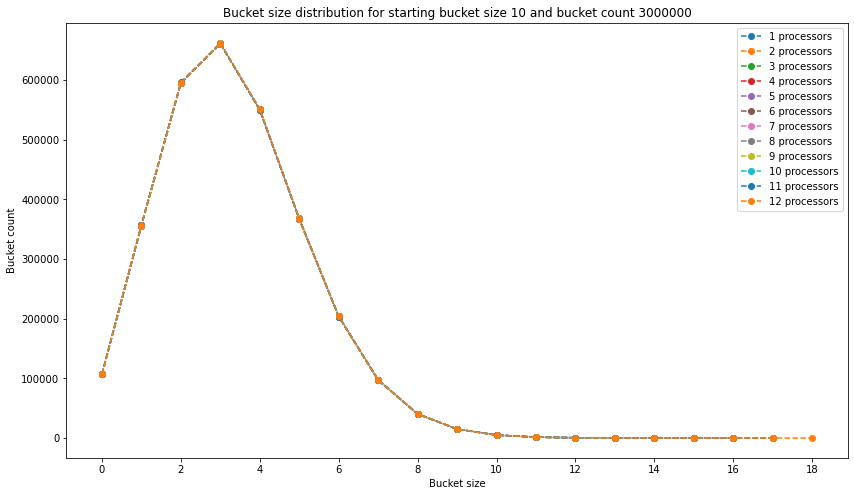

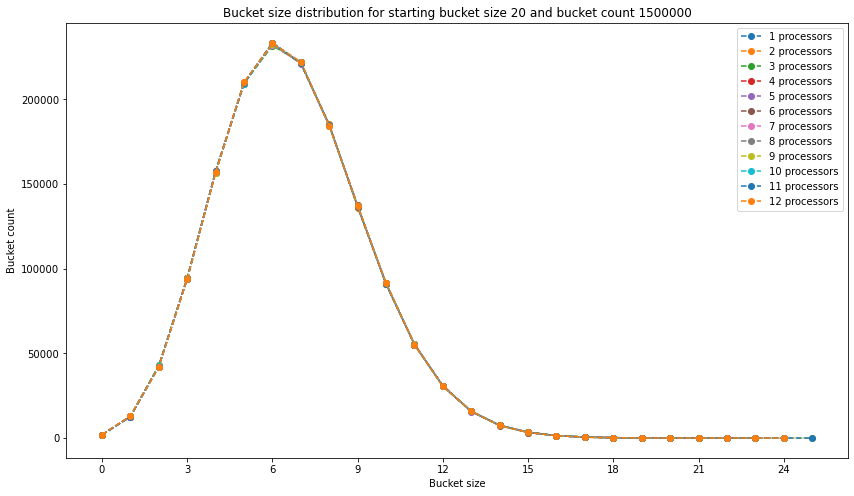

In [14]:
plot_distributions(read_slurm("slurm-20358413.out"))

In [31]:
dists = read_slurm("slurm_test.txt")
dists[1].thread_distributions[1].buckets_to_counts

{1: 4.06,
 2: 10.74,
 3: 46.78,
 4: 151.09,
 5: 425.97,
 6: 977.22,
 7: 1843.14,
 8: 3007.13,
 9: 4410.42,
 10: 5888.03,
 11: 7224.14,
 12: 8006.23,
 13: 8225.81,
 14: 7899.38,
 15: 6919.73,
 16: 5753.66,
 17: 4571.89,
 18: 3370.43,
 19: 2321.64,
 20: 1562.74,
 21: 994.41,
 22: 596.7,
 23: 369.73,
 24: 200.85,
 25: 112.51,
 26: 58.26,
 27: 28.21,
 28: 12.73,
 29: 4.77,
 30: 2.01,
 31: 1.38,
 32: 0.16,
 33: 0.05}

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

No handles with labels found to put in legend.


[[-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 ...
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]]
[[-5.   -5.   -5.   ... -5.   -5.   -5.  ]
 [-4.75 -4.75 -4.75 ... -4.75 -4.75 -4.75]
 [-4.5  -4.5  -4.5  ... -4.5  -4.5  -4.5 ]
 ...
 [ 4.25  4.25  4.25 ...  4.25  4.25  4.25]
 [ 4.5   4.5   4.5  ...  4.5   4.5   4.5 ]
 [ 4.75  4.75  4.75 ...  4.75  4.75  4.75]]


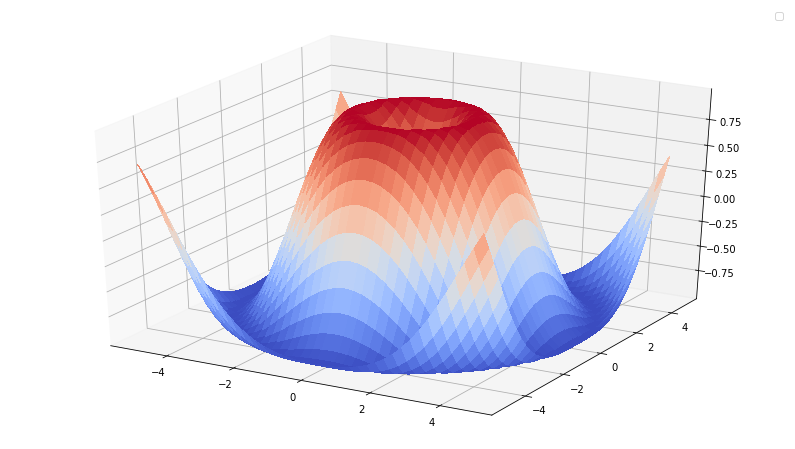

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(X)
print(Y)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.legend()

In [ ]:
# DANGEROUS BELOW

In [31]:
PLOT_COLORS = ['b', 'g', 'orange']
SIZE_LABELS = ["small: ", "medium: ", "big: "]

class SlurmData:
    def __init__(self):
        self.point_counts = []
        self.pi_vals: Dict[int, List[float]] = defaultdict(lambda: [])
        self.times: Dict[int, List[float]] = defaultdict(lambda: [])
            
class DataAnaylzer:
    OUTLIERS = [(0, 3, 16), (0, 3, 17), (0, 7, 1), (2, 9, 16)]
    
    def __init__(self, slurm_data: List[SlurmData]):
        self.slurm_data = slurm_data
        for point_idx, proc_idx, test_idx in reversed(DataAnaylzer.OUTLIERS):
            point_count = self.slurm_data[0].point_counts[point_idx]
            self.slurm_data[test_idx].times[point_count][proc_idx] = -1
        
    def apply_on_times(self, reduce_function) -> SlurmData:
        res = SlurmData()
        for point_count in self.slurm_data[0].point_counts:
            res.point_counts.append(point_count)
            for i in range(0, 12):
                proc_times = np.array(list(map(lambda data: data.times[point_count][i],
                                               filter(lambda data: data.times[point_count][i] > 0,
                                                      self.slurm_data))))
                res.times[point_count].append(reduce_function(proc_times))
        return res
    
    def analyze_times_for_proc(self, p_idx: int, proc: int):
        point_count = self.slurm_data[0].point_counts[p_idx]
        res = []
        for data in self.slurm_data:
            res.append(data.times[point_count][proc])
        return res
    
def to_exp_string(number: float):
    pwr = 0
    while number >= 10:
        number /= 10
        pwr += 1
    number = round(number, 2)
    return '$' + str(number) + "*10^{" + str(pwr) + "}$"

def single_legend(i: int, number: float):
    return SIZE_LABELS[i] + to_exp_string(number) + " points"

def parse_single_slurm_file(filename: str):
    data = SlurmData()
    with open(filename, 'r') as handle:
        point_count = 0
        for line in handle.readlines():
            if line.startswith("Point count:"):
                point_count = int(line.split(':')[1])
                if point_count not in data.point_counts:
                    data.point_counts.append(point_count)
    
            elif line.startswith("Total time:"): 
                time = float(line.split(':')[1])
                data.times[point_count].append(time)
            elif line.startswith("PI value:"): 
                pi = float(line.split(':')[1])
                data.pi_vals[point_count].append(pi)
    return data

def read_slurm_files():
    total_data = []
    for filename in os.listdir("."):
        if filename.startswith("slurm"):
            total_data.append(parse_single_slurm_file(filename))
    return total_data

def plot_time(time_mean: SlurmData, time_std: SlurmData, num: int):
    point_count = time_mean.point_counts[num]
    plt.errorbar(range(1,13), time_mean.times[point_count], marker = 'o', color=PLOT_COLORS[num],
                 yerr=time_std.times[point_count], linestyle='--', ecolor='red', label=single_legend(num, point_count))
    plt.xlim(0)
    plt.title(f"Execution time on processors for {SIZE_LABELS[num][:-2]}")
    plt.ylabel("Time [s]")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig(f"time_{num}.png")
    plt.show()
    
def plot_speedup(time_mean: SlurmData):
    plt.plot(range(1,13), range(1,13), color = 'r', label='y=x')
    speedup_mapping = {}
    for i, point_count in enumerate(time_mean.point_counts):
        speedup = time_mean.times[point_count][0] / np.array(time_mean.times[point_count])
        speedup_mapping[point_count] = speedup
        data_to_plot = speedup
        plt.plot(range(1,13), data_to_plot, marker = 'o', color=PLOT_COLORS[i],
                 linestyle='--', label=single_legend(i, point_count))
    plt.ylim(0)
    plt.title("Speedup on processors")
    plt.ylabel("Speedup")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig("speedup.png")
    plt.show()
    return speedup_mapping
    
def plot_efficiency(time_mean: SlurmData):
    plt.plot(range(1,13), [1]*12, color = 'r')
    plt.plot(range(1,13), [0.8]*12, color = 'm', linestyle=':')
    proc_count = range(1,13)
    
    for i, point_count in enumerate(time_mean.point_counts):
        data_to_plot = time_mean.times[point_count][0] / (proc_count * np.array(time_mean.times[point_count]))
        plt.plot(range(1,13), data_to_plot, marker = 'o', color=PLOT_COLORS[i],
                 linestyle='--', label=single_legend(i, point_count))
    plt.ylim(0)
    plt.title("Efficiency on processors")
    plt.ylabel("Efficiency")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig("efficiency.png")
    plt.show()
    
def plot_serial_fraction(speedup: Dict[int, np.array]): 
    proc_count = np.array(range(2, 13))
    for i, point_count in enumerate(time_mean.point_counts):
        data_to_plot = (1 / speedup[point_count][1:]  -  1 / proc_count) / (1 - 1 / proc_count)
        plt.plot(range(2,13), data_to_plot, marker = 'o', color=PLOT_COLORS[i],
                 linestyle='--', label=single_legend(i, point_count))
    plt.ylim(0,1)
    plt.xlim(0)
    plt.title("Serial fraction on processors")
    plt.ylabel("Serial fraction")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig("sf.png")
    plt.show()

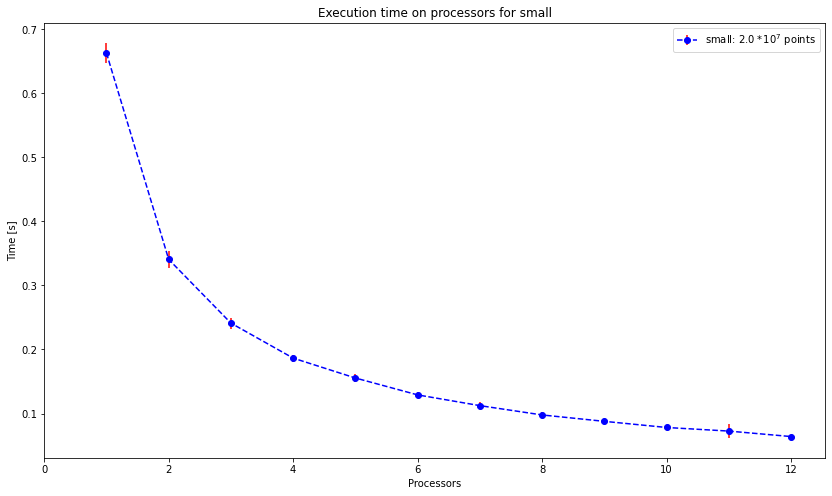

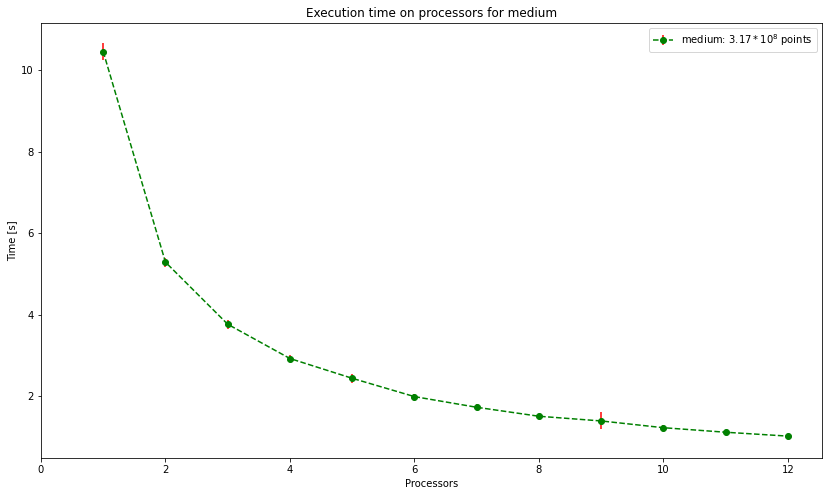

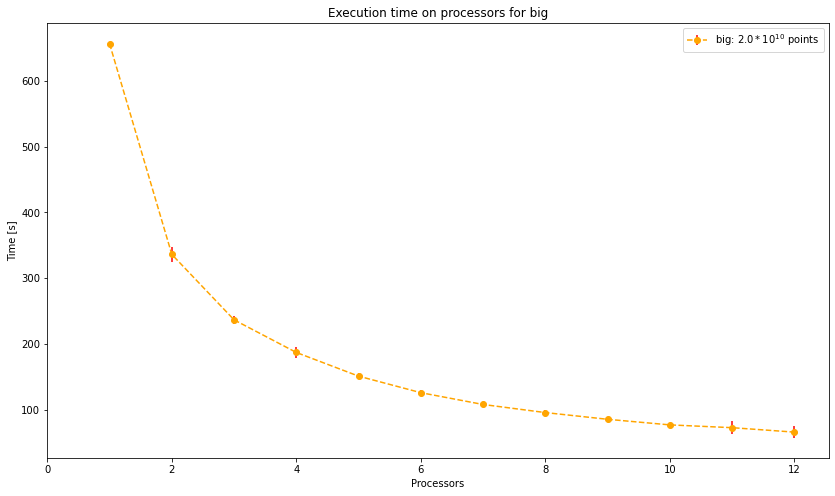

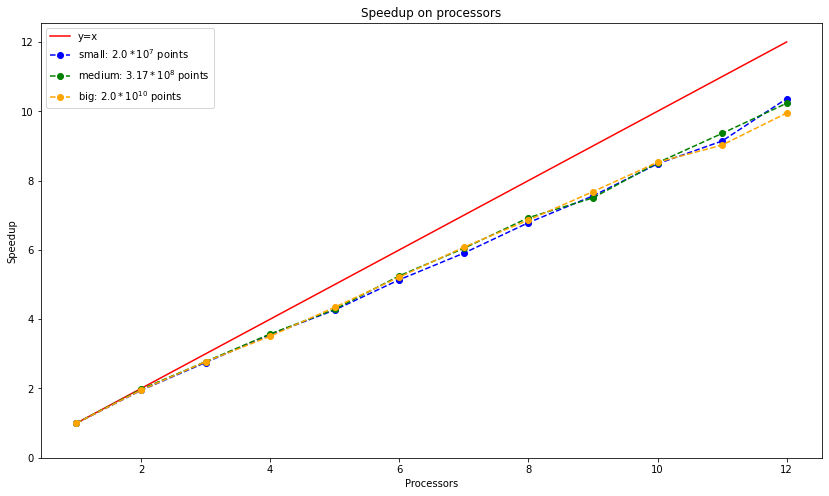

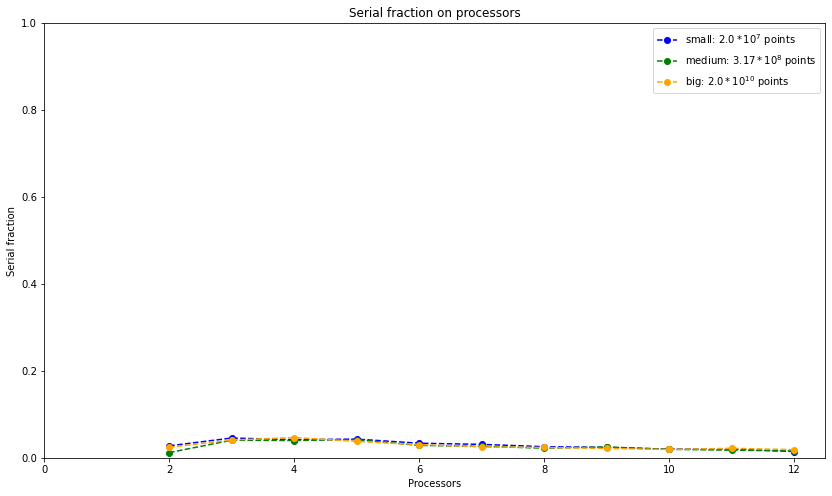

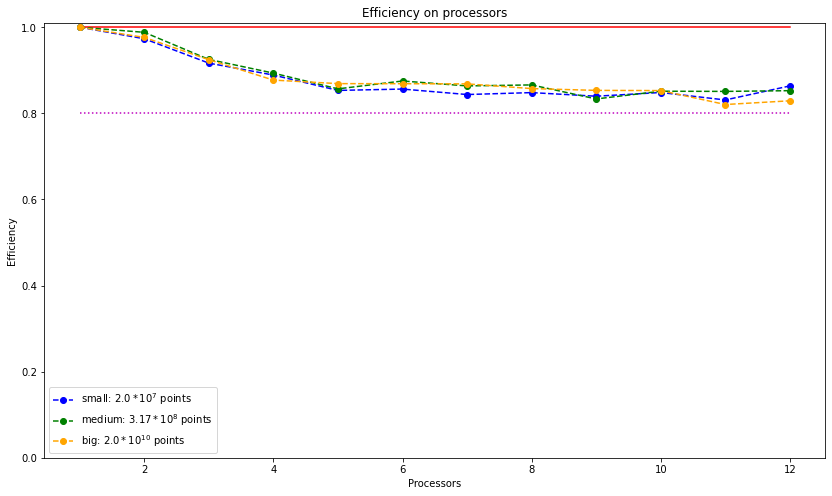

In [34]:
analyzer = DataAnaylzer(read_slurm_files())
time_mean = analyzer.apply_on_times(np.mean)
time_std = analyzer.apply_on_times(np.std)

plot_time(time_mean, time_std, 0)
plot_time(time_mean, time_std, 1)
plot_time(time_mean, time_std, 2)
plot_serial_fraction(plot_speedup(time_mean))
plot_efficiency(time_mean)

In [33]:
for x, y, z in zip(analyzer.analyze_times_for_proc(0, 3),
                   analyzer.analyze_times_for_proc(2, 3),
                   analyzer.analyze_times_for_proc(2, 9)):
    print(x, y, z)


0.183254 184.53227 82.544065
0.181096 180.687069 74.698006
0.185977 202.566413 74.60009
0.185076 183.829626 74.675059
0.186796 200.072203 74.686441
0.184825 183.981968 82.622992
0.185639 180.698349 82.548365
0.183909 183.160705 74.611384
0.201682 183.996494 74.65964
0.18557 180.32174 74.599061
0.186218 203.569451 82.545664
0.181477 180.442173 74.684252
0.18347 183.927826 74.685783
0.181402 200.075248 82.606797
0.183637 183.651181 74.678899
0.181418 180.949414 74.652735
-1 183.974056 -1
-1 200.002346 82.536047
0.182963 184.120478 74.684621
0.188861 180.709218 74.695442
0.190845 183.901108 74.669468
0.200788 180.690397 74.646568
0.188065 183.428129 74.674037
0.190875 199.57733 74.648615
0.185418 183.93264 82.496674
